### Read data

In [11]:
import pickle

with open("data.p", "rb") as f:
    faces = pickle.load(f)
    
images = faces.images    
targets = faces.target
target_names = faces.target_names

print(targets.shape)
print(images.shape)
print(images[0].shape)

(1348,)
(1348, 62, 47)
(62, 47)


### Data Visualization

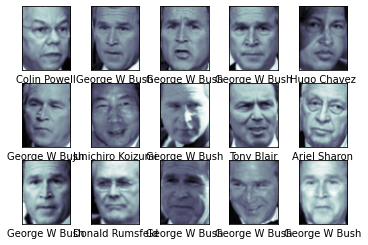

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd




fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(images[i], cmap='bone')
    axi.set(xticks=[], yticks=[], xlabel=target_names[targets[i]])

# Предобработка данных 

In [13]:
images = images.reshape(1348, -1)  # преобразуем каждую картинку в вектор
images = (images - images.mean()) / images.std()  # стандартизация для более стабильного обучения

In [14]:
from sklearn.model_selection import train_test_split
# делим данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(images, targets, random_state=42, test_size=0.25, stratify=targets)

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=256)
pca.fit(X_train)


X_train_proj = pca.transform(X_train)
X_test_proj = pca.transform(X_test)

<Figure size 648x432 with 0 Axes>

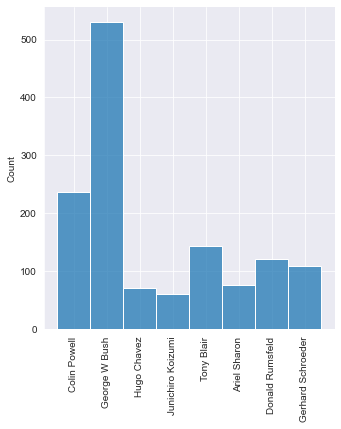

In [16]:
plt.figure(figsize=(9,6))
sns.set_style("darkgrid")
sns.displot([target_names[x] for x in targets])
plt.xticks(rotation=90)

plt.show()

# Обучение SVM и случайного леса

In [17]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [18]:
# увеличиваем вес l2 нормы весов, тем самым уменьшая переобучение, задаем веса классам
svc = SVC(probability=True, C=3.0, class_weight='balanced') 

# задаем веса классам
rfc = RandomForestClassifier(class_weight='balanced')

In [19]:
# обучаем svc
svc.fit(X_train, y_train)

SVC(C=3.0, class_weight='balanced', probability=True)

In [20]:
# обучаем лес
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [21]:
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score

def print_metrics(estimator, X_train, X_test, y_train, y_test):
    pred_train = estimator.predict_proba(X_train)
    pred_test = estimator.predict_proba(X_test)
    
    print('Train accuracy:', estimator.score(X_train, y_train))
    print('Test accuracy:', estimator.score(X_test, y_test))
    
    print('Train roc auc score:', 
          roc_auc_score(y_train, pred_train, average='macro', multi_class='ovr'))
    print('Test roc auc score:', 
          roc_auc_score(y_test, pred_test, average='macro', multi_class='ovr'))

In [22]:
from sklearn.metrics import confusion_matrix

def make_conf_matrix_plot(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)
    
    plt.figure(figsize=(9,6))
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()
    

In [23]:
# метрики для svc
print_metrics(svc, X_train, X_test, y_train, y_test)

Train accuracy: 0.9930761622156281
Test accuracy: 0.8249258160237388
Train roc auc score: 0.9999873587351031
Test roc auc score: 0.9743865581756226


In [24]:
# метрики для cckлеса
print_metrics(rfc, X_train, X_test, y_train, y_test)

Train accuracy: 1.0
Test accuracy: 0.6320474777448071
Train roc auc score: 1.0
Test roc auc score: 0.9377326224090665


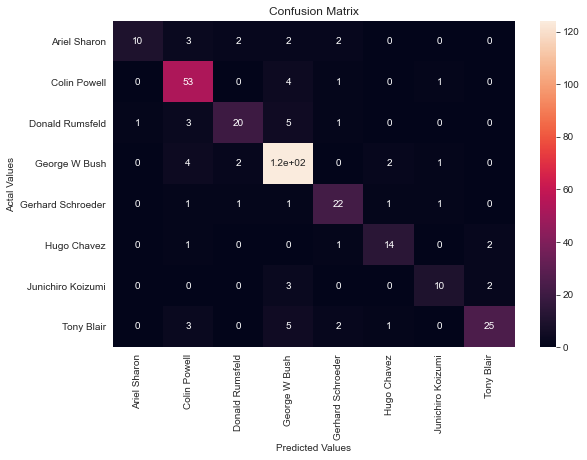

In [25]:
make_conf_matrix_plot(y_test, svc.predict(X_test), target_names)

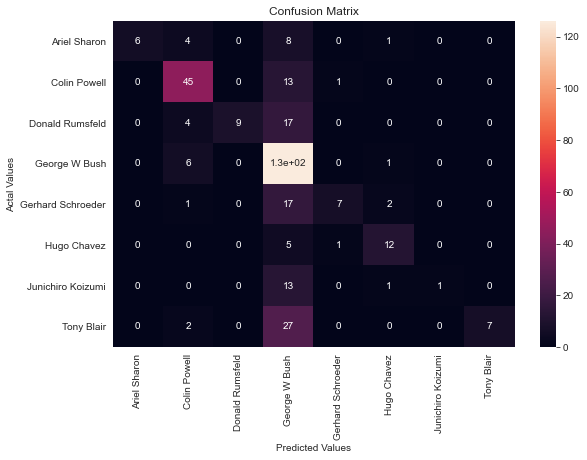

In [26]:
make_conf_matrix_plot(y_test, rfc.predict(X_test), target_names)

In [27]:
# видно, что лес плохо справляется с дисбалансом классов

# Обучение на данных пониженной размерности 

In [28]:
svc.fit(X_train_proj, y_train)
rfc.fit(X_train_proj, y_train)


RandomForestClassifier(class_weight='balanced')

In [29]:
print_metrics(svc, X_train_proj, X_test_proj, y_train, y_test)

Train accuracy: 0.9980217606330366
Test accuracy: 0.8041543026706232
Train roc auc score: 0.999998461588953
Test roc auc score: 0.9726767237935137


In [30]:
print_metrics(rfc, X_train_proj, X_test_proj, y_train, y_test)

Train accuracy: 1.0
Test accuracy: 0.4362017804154303
Train roc auc score: 1.0
Test roc auc score: 0.8992201307544025


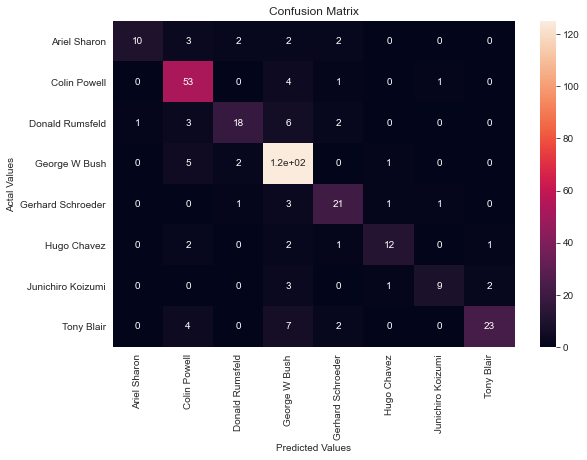

In [31]:
make_conf_matrix_plot(y_test, svc.predict(X_test_proj), target_names)


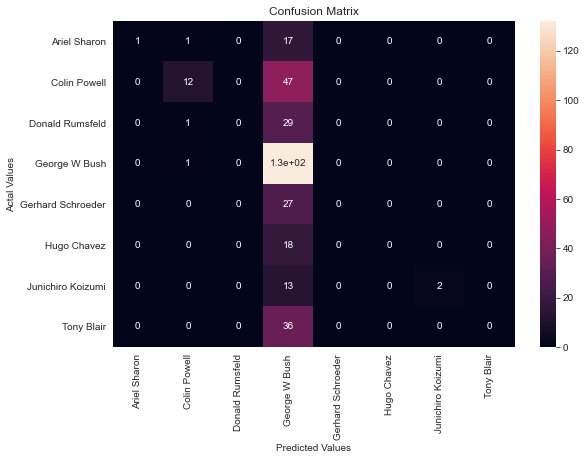

In [32]:
make_conf_matrix_plot(y_test, rfc.predict(X_test_proj), target_names)

# Перебор параметров

In [33]:
from sklearn.model_selection import GridSearchCV
svc_parameters = {'probability': [True], 'kernel':('linear', 'rbf'),
                  'C': [1.0, 3.0, 10.0], 'class_weight': ['balanced']}

rfc_parameters = {'n_estimators': (50, 100, 150), 'max_depth': (5, 7, None), 'class_weight': ['balanced']}



In [36]:
svc_gridsearch = GridSearchCV(svc, svc_parameters, cv=3, verbose=True)
svc_gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  3.4min finished


GridSearchCV(cv=3,
             estimator=SVC(C=3.0, class_weight='balanced', probability=True),
             param_grid={'C': [1.0, 5.0, 10.0], 'class_weight': ['balanced'],
                         'kernel': ('linear', 'rbf'), 'probability': [True]},
             verbose=True)

In [37]:
rfc_gridsearch = GridSearchCV(rfc, rfc_parameters, cv=3)
rfc_gridsearch.fit(X_train, y_train)


GridSearchCV(cv=3, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'class_weight': ['balanced'],
                         'max_depth': (5, 7, None),
                         'n_estimators': (50, 100, 150)})

In [38]:
print_metrics(svc_gridsearch.best_estimator_, X_train, X_test, y_train, y_test)

Train accuracy: 1.0
Test accuracy: 0.8160237388724035
Train roc auc score: 1.0
Test roc auc score: 0.9712972273056003


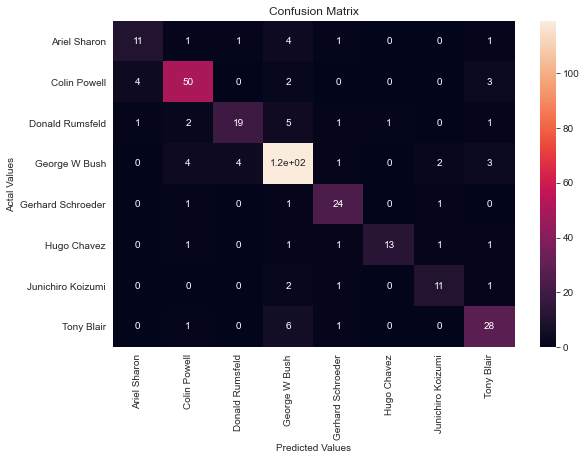

In [41]:
make_conf_matrix_plot(y_test, svc_gridsearch.best_estimator_.predict(X_test), target_names)

In [40]:
print_metrics(rfc_gridsearch.best_estimator_, X_train, X_test, y_train, y_test)

Train accuracy: 1.0
Test accuracy: 0.7091988130563798
Train roc auc score: 0.9999679029465718
Test roc auc score: 0.9198422449467267


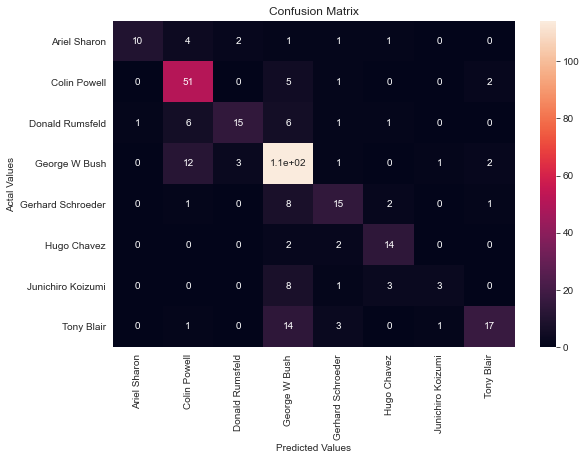

In [42]:
make_conf_matrix_plot(y_test, rfc_gridsearch.best_estimator_.predict(X_test), target_names)